In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tensorflow as tf

from torch.autograd import Variable
from torchvision.models import resnet18

from tensorflow import keras
from keras.preprocessing import image

import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics

torch.manual_seed(777)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
        torch.cuda.manual_seed(777)

In [84]:
class NetVLAD(nn.Module):
    """NetVLAD layer implementation"""

    def __init__(self, num_clusters=6, dim=128, alpha=100.0,
                 normalize_input=True):
        """
        Args:
            num_clusters : int
                The number of clusters
            dim : int
                Dimension of descriptors
            alpha : float
                Parameter of initialization. Larger value is harder assignment.
            normalize_input : bool
                If true, descriptor-wise L2 normalization is applied to input.
        """
        super(NetVLAD, self).__init__()
        self.num_clusters = num_clusters
        self.dim = dim
        self.alpha = alpha
        self.normalize_input = normalize_input
        self.conv = nn.Conv2d(dim, num_clusters, kernel_size=(1, 1), bias=True)
        self.centroids = nn.Parameter(torch.rand(num_clusters, dim))
        self._init_params()

    def _init_params(self):
        self.conv.weight = nn.Parameter(
            (2.0 * self.alpha * self.centroids).unsqueeze(-1).unsqueeze(-1)
        )
        self.conv.bias = nn.Parameter(
            - self.alpha * self.centroids.norm(dim=1)
        )

    def forward(self, x):
        N, C = x.shape[:2]

        if self.normalize_input:
            x = F.normalize(x, p=2, dim=1)  # across descriptor dim

        # soft-assignment
        soft_assign = self.conv(x).view(N, self.num_clusters, -1)
        soft_assign = F.softmax(soft_assign, dim=1)

        x_flatten = x.view(N, C, -1)
        
        # calculate residuals to each clusters
        residual = x_flatten.expand(self.num_clusters, -1, -1, -1).permute(1, 0, 2, 3) - \
            self.centroids.expand(x_flatten.size(-1), -1, -1).permute(1, 2, 0).unsqueeze(0)
        residual *= soft_assign.unsqueeze(2)
        vlad = residual.sum(dim=-1)

        vlad = F.normalize(vlad, p=2, dim=2)  # intra-normalization
        vlad = vlad.view(x.size(0), -1)  # flatten
        vlad = F.normalize(vlad, p=2, dim=1)  # L2 normalize

        return vlad

In [85]:
class EmbedNet(nn.Module):
    def __init__(self, base_model, net_vlad):
        super(EmbedNet, self).__init__()
        self.base_model = base_model
        self.net_vlad = net_vlad

    def forward(self, x):
        x = self.base_model(x)
        embedded_x = self.net_vlad(x)
        return embedded_x
      
class TripletNet(nn.Module):
    def __init__(self, embed_net):
        super(TripletNet, self).__init__()
        self.embed_net = embed_net

    def forward(self, a, p, n):
        embedded_a = self.embed_net(a)
        embedded_p = self.embed_net(p)
        embedded_n = self.embed_net(n)
        return embedded_a, embedded_p, embedded_n

    def feature_extract(self, x):
        return self.embed_net(x)

In [86]:
class HardTripletLoss(nn.Module):
    """Hard/Hardest Triplet Loss
    (pytorch implementation of https://omoindrot.github.io/triplet-loss)
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    """
    def __init__(self, margin=0.1, hardest=False, squared=False):
        """
        Args:
            margin: margin for triplet loss
            hardest: If true, loss is considered only hardest triplets.
            squared: If true, output is the pairwise squared euclidean distance matrix.
                If false, output is the pairwise euclidean distance matrix.
        """
        super(HardTripletLoss, self).__init__()
        self.margin = margin
        self.hardest = hardest
        self.squared = squared

    def forward(self, embeddings, labels):
        """
        Args:
            labels: labels of the batch, of size (batch_size,)
            embeddings: tensor of shape (batch_size, embed_dim)
        Returns:
            triplet_loss: scalar tensor containing the triplet loss
        """
        pairwise_dist = _pairwise_distance(embeddings, squared=self.squared)

        if self.hardest:
            # Get the hardest positive pairs
            mask_anchor_positive = _get_anchor_positive_triplet_mask(labels).float()
            valid_positive_dist = pairwise_dist * mask_anchor_positive
            hardest_positive_dist, _ = torch.max(valid_positive_dist, dim=1, keepdim=True)

            # Get the hardest negative pairs
            mask_anchor_negative = _get_anchor_negative_triplet_mask(labels).float()
            max_anchor_negative_dist, _ = torch.max(pairwise_dist, dim=1, keepdim=True)
            anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (
                    1.0 - mask_anchor_negative)
            hardest_negative_dist, _ = torch.min(anchor_negative_dist, dim=1, keepdim=True)

            # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
            triplet_loss = F.relu(hardest_positive_dist - hardest_negative_dist + 0.1)
            triplet_loss = torch.mean(triplet_loss)
        else:
            anc_pos_dist = pairwise_dist.unsqueeze(dim=2)
            anc_neg_dist = pairwise_dist.unsqueeze(dim=1)

            # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
            # triplet_loss[i, j, k] will contain the triplet loss of anc=i, pos=j, neg=k
            # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
            # and the 2nd (batch_size, 1, batch_size)
            loss = anc_pos_dist - anc_neg_dist + self.margin

            mask = _get_triplet_mask(labels).float()
            triplet_loss = loss * mask

            # Remove negative losses (i.e. the easy triplets)
            triplet_loss = F.relu(triplet_loss)

            # Count number of hard triplets (where triplet_loss > 0)
            hard_triplets = torch.gt(triplet_loss, 1e-16).float()
            num_hard_triplets = torch.sum(hard_triplets)

            triplet_loss = torch.sum(triplet_loss) / (num_hard_triplets + 1e-16)

        return triplet_loss


def _pairwise_distance(x, squared=False, eps=1e-16):
    # Compute the 2D matrix of distances between all the embeddings.

    cor_mat = torch.matmul(x, x.t())
    norm_mat = cor_mat.diag()
    distances = norm_mat.unsqueeze(1) - 2 * cor_mat + norm_mat.unsqueeze(0)
    distances = F.relu(distances)

    if not squared:
        mask = torch.eq(distances, 0.0).float()
        distances = distances + mask * eps
        distances = torch.sqrt(distances)
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    # Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    indices_not_equal = torch.eye(labels.shape[0]).to(device).byte() ^ 1

    # Check if labels[i] == labels[j]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)

    mask = indices_not_equal * labels_equal

    return mask


def _get_anchor_negative_triplet_mask(labels):
    # Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.

    # Check if labels[i] != labels[k]
    labels_equal = torch.unsqueeze(labels, 0) == torch.unsqueeze(labels, 1)
    mask = labels_equal ^ 1

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Check that i, j and k are distinct
    indices_not_same = torch.eye(labels.shape[0]).to(device).byte() ^ 1
    i_not_equal_j = torch.unsqueeze(indices_not_same, 2)
    i_not_equal_k = torch.unsqueeze(indices_not_same, 1)
    j_not_equal_k = torch.unsqueeze(indices_not_same, 0)
    distinct_indices = i_not_equal_j * i_not_equal_k * j_not_equal_k

    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = torch.eq(torch.unsqueeze(labels, 0), torch.unsqueeze(labels, 1))
    i_equal_j = torch.unsqueeze(label_equal, 2)
    i_equal_k = torch.unsqueeze(label_equal, 1)
    valid_labels = i_equal_j * (~i_equal_k)

    mask = distinct_indices * valid_labels   # Combine the two masks

    return mask

In [87]:
# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=6, dim=dim, alpha=1.0)
model = EmbedNet(base_model, net_vlad).cuda()

In [88]:
# Define loss
criterion = HardTripletLoss(margin=0.1).cuda()
epochs = 50
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [89]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),               
    torchvision.transforms.ToTensor()
    
])

bef_train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/train', transform=transforms)
bef_train_data_loader = torch.utils.data.DataLoader(bef_train_imagenet_data,
                                          batch_size=776,
                                          shuffle=False,
                                          num_workers=0)

In [90]:
bef_train_data_loader

In [91]:
for bef_train_image,bef_train_label in bef_train_data_loader :
#     print(bef_train_image)
#     print(bef_train_lable)
    bef_train_image = bef_train_image
    bef_train_label = bef_train_label

In [92]:
bef_train_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [93]:
bef_train_image

tensor([[[[0.8667, 0.8667, 0.8627,  ..., 0.9137, 0.9137, 0.9137],
          [0.8667, 0.8627, 0.8627,  ..., 0.9137, 0.9137, 0.9098],
          [0.8667, 0.8627, 0.8667,  ..., 0.9137, 0.9137, 0.9137],
          ...,
          [0.4549, 0.7294, 0.6667,  ..., 0.6627, 0.7176, 0.7529],
          [0.5373, 0.7294, 0.4941,  ..., 0.6392, 0.6549, 0.7098],
          [0.3412, 0.4824, 0.3059,  ..., 0.6431, 0.6392, 0.6510]],

         [[0.9647, 0.9647, 0.9647,  ..., 0.9882, 0.9882, 0.9843],
          [0.9686, 0.9686, 0.9647,  ..., 0.9882, 0.9882, 0.9843],
          [0.9686, 0.9686, 0.9686,  ..., 0.9882, 0.9882, 0.9882],
          ...,
          [0.5137, 0.8118, 0.7451,  ..., 0.6941, 0.6863, 0.6980],
          [0.6039, 0.8078, 0.5608,  ..., 0.6863, 0.6784, 0.6824],
          [0.4039, 0.5608, 0.3647,  ..., 0.6941, 0.6902, 0.6706]],

         [[0.9569, 0.9569, 0.9608,  ..., 0.9804, 0.9804, 0.9804],
          [0.9569, 0.9569, 0.9569,  ..., 0.9804, 0.9804, 0.9804],
          [0.9569, 0.9569, 0.9569,  ..., 0

In [94]:
train_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/train', transform=transforms)
train_data_loader = torch.utils.data.DataLoader(train_imagenet_data,
                                          batch_size=8,
                                          shuffle=True,
                                          num_workers=0)
test_imagenet_data = torchvision.datasets.ImageFolder('/home/jun/Data/F4-E5/test', transform=transforms)
test_data_loader = torch.utils.data.DataLoader(test_imagenet_data,
                                          shuffle=False,
                                          batch_size=100,
                                          num_workers=0)

In [95]:
globaliter = 0

for epoch in range(epochs):
  for batch_idx, (train_image,train_label) in enumerate(train_data_loader) :
    output_train = model(train_image.cuda())
    triplet_loss = criterion(output_train, train_label.cuda())
    optimizer.zero_grad()
    triplet_loss.backward(retain_graph=True)
    optimizer.step()
    # This is where I'm recording to Tensorboard
    # tb.save_value('Train Loss', 'train_loss', globaliter, triplet_loss.item())
    print('epoch : {}, globaliter : {}, batch_idx  : {}, triplet_loss : {}'.format(epoch,globaliter,batch_idx,triplet_loss.item()))
    globaliter += 1
  model_save_name = 'model_{:02d}.pt'.format(epoch)
  path = F"/home/jun/Data/F4-E5/models/{model_save_name}" 
  torch.save(model.state_dict(), path)

epoch : 0, globaliter : 0, batch_idx  : 0, triplet_loss : 0.09585832804441452
epoch : 0, globaliter : 1, batch_idx  : 1, triplet_loss : 0.09902789443731308
epoch : 0, globaliter : 2, batch_idx  : 2, triplet_loss : 0.09864405542612076
epoch : 0, globaliter : 3, batch_idx  : 3, triplet_loss : 0.09660431742668152
epoch : 0, globaliter : 4, batch_idx  : 4, triplet_loss : 0.0986531674861908
epoch : 0, globaliter : 5, batch_idx  : 5, triplet_loss : 0.09714357554912567
epoch : 0, globaliter : 6, batch_idx  : 6, triplet_loss : 0.10020574182271957
epoch : 0, globaliter : 7, batch_idx  : 7, triplet_loss : 0.09652034193277359
epoch : 0, globaliter : 8, batch_idx  : 8, triplet_loss : 0.09794033318758011
epoch : 0, globaliter : 9, batch_idx  : 9, triplet_loss : 0.09922110289335251
epoch : 0, globaliter : 10, batch_idx  : 10, triplet_loss : 0.09715011715888977
epoch : 0, globaliter : 11, batch_idx  : 11, triplet_loss : 0.0997803658246994
epoch : 0, globaliter : 12, batch_idx  : 12, triplet_loss : 0.

epoch : 2, globaliter : 104, batch_idx  : 16, triplet_loss : 0.0968986377120018
epoch : 2, globaliter : 105, batch_idx  : 17, triplet_loss : 0.09306350350379944
epoch : 2, globaliter : 106, batch_idx  : 18, triplet_loss : 0.09091245383024216
epoch : 2, globaliter : 107, batch_idx  : 19, triplet_loss : 0.092427559196949
epoch : 2, globaliter : 108, batch_idx  : 20, triplet_loss : 0.09689638763666153
epoch : 2, globaliter : 109, batch_idx  : 21, triplet_loss : 0.09713474661111832
epoch : 2, globaliter : 110, batch_idx  : 22, triplet_loss : 0.09559985995292664
epoch : 2, globaliter : 111, batch_idx  : 23, triplet_loss : 0.10006391257047653
epoch : 2, globaliter : 112, batch_idx  : 24, triplet_loss : 0.09240668267011642
epoch : 2, globaliter : 113, batch_idx  : 25, triplet_loss : 0.0973314493894577
epoch : 2, globaliter : 114, batch_idx  : 26, triplet_loss : 0.09533479809761047
epoch : 2, globaliter : 115, batch_idx  : 27, triplet_loss : 0.09469806402921677
epoch : 2, globaliter : 116, bat

epoch : 4, globaliter : 206, batch_idx  : 30, triplet_loss : 0.08692172169685364
epoch : 4, globaliter : 207, batch_idx  : 31, triplet_loss : 0.08833236247301102
epoch : 4, globaliter : 208, batch_idx  : 32, triplet_loss : 0.09618009626865387
epoch : 4, globaliter : 209, batch_idx  : 33, triplet_loss : 0.09216505289077759
epoch : 4, globaliter : 210, batch_idx  : 34, triplet_loss : 0.08936050534248352
epoch : 4, globaliter : 211, batch_idx  : 35, triplet_loss : 0.0827891156077385
epoch : 4, globaliter : 212, batch_idx  : 36, triplet_loss : 0.08859659731388092
epoch : 4, globaliter : 213, batch_idx  : 37, triplet_loss : 0.09056056290864944
epoch : 4, globaliter : 214, batch_idx  : 38, triplet_loss : 0.08859892189502716
epoch : 4, globaliter : 215, batch_idx  : 39, triplet_loss : 0.0907687172293663
epoch : 4, globaliter : 216, batch_idx  : 40, triplet_loss : 0.09428529441356659
epoch : 4, globaliter : 217, batch_idx  : 41, triplet_loss : 0.08437439054250717
epoch : 4, globaliter : 218, b

epoch : 7, globaliter : 309, batch_idx  : 1, triplet_loss : 0.0695025771856308
epoch : 7, globaliter : 310, batch_idx  : 2, triplet_loss : 0.06623278558254242
epoch : 7, globaliter : 311, batch_idx  : 3, triplet_loss : 0.06917057186365128
epoch : 7, globaliter : 312, batch_idx  : 4, triplet_loss : 0.06541319191455841
epoch : 7, globaliter : 313, batch_idx  : 5, triplet_loss : 0.07553723454475403
epoch : 7, globaliter : 314, batch_idx  : 6, triplet_loss : 0.08894336223602295
epoch : 7, globaliter : 315, batch_idx  : 7, triplet_loss : 0.06382527947425842
epoch : 7, globaliter : 316, batch_idx  : 8, triplet_loss : 0.07284948229789734
epoch : 7, globaliter : 317, batch_idx  : 9, triplet_loss : 0.0946153923869133
epoch : 7, globaliter : 318, batch_idx  : 10, triplet_loss : 0.07675040513277054
epoch : 7, globaliter : 319, batch_idx  : 11, triplet_loss : 0.07716426253318787
epoch : 7, globaliter : 320, batch_idx  : 12, triplet_loss : 0.0862697884440422
epoch : 7, globaliter : 321, batch_idx  

epoch : 9, globaliter : 411, batch_idx  : 15, triplet_loss : 0.05375780910253525
epoch : 9, globaliter : 412, batch_idx  : 16, triplet_loss : 0.04156643897294998
epoch : 9, globaliter : 413, batch_idx  : 17, triplet_loss : 0.05719875544309616
epoch : 9, globaliter : 414, batch_idx  : 18, triplet_loss : 0.0887865349650383
epoch : 9, globaliter : 415, batch_idx  : 19, triplet_loss : 0.057342562824487686
epoch : 9, globaliter : 416, batch_idx  : 20, triplet_loss : 0.06681175529956818
epoch : 9, globaliter : 417, batch_idx  : 21, triplet_loss : 0.05387944355607033
epoch : 9, globaliter : 418, batch_idx  : 22, triplet_loss : 0.06952224671840668
epoch : 9, globaliter : 419, batch_idx  : 23, triplet_loss : 0.03778475150465965
epoch : 9, globaliter : 420, batch_idx  : 24, triplet_loss : 0.07933228462934494
epoch : 9, globaliter : 421, batch_idx  : 25, triplet_loss : 0.06451968103647232
epoch : 9, globaliter : 422, batch_idx  : 26, triplet_loss : 0.06103051081299782
epoch : 9, globaliter : 423,

epoch : 11, globaliter : 512, batch_idx  : 28, triplet_loss : 0.08483382314443588
epoch : 11, globaliter : 513, batch_idx  : 29, triplet_loss : 0.08494508266448975
epoch : 11, globaliter : 514, batch_idx  : 30, triplet_loss : 0.08506616950035095
epoch : 11, globaliter : 515, batch_idx  : 31, triplet_loss : 0.035568855702877045
epoch : 11, globaliter : 516, batch_idx  : 32, triplet_loss : 0.04427904635667801
epoch : 11, globaliter : 517, batch_idx  : 33, triplet_loss : 0.01815684698522091
epoch : 11, globaliter : 518, batch_idx  : 34, triplet_loss : 0.025746023282408714
epoch : 11, globaliter : 519, batch_idx  : 35, triplet_loss : 0.07786095887422562
epoch : 11, globaliter : 520, batch_idx  : 36, triplet_loss : 0.05088100954890251
epoch : 11, globaliter : 521, batch_idx  : 37, triplet_loss : 0.04930179938673973
epoch : 11, globaliter : 522, batch_idx  : 38, triplet_loss : 0.017657382413744926
epoch : 11, globaliter : 523, batch_idx  : 39, triplet_loss : 0.05244392901659012
epoch : 11, g

epoch : 13, globaliter : 613, batch_idx  : 41, triplet_loss : 0.06261889636516571
epoch : 13, globaliter : 614, batch_idx  : 42, triplet_loss : 0.053909916430711746
epoch : 13, globaliter : 615, batch_idx  : 43, triplet_loss : 0.0
epoch : 14, globaliter : 616, batch_idx  : 0, triplet_loss : 0.0076516373082995415
epoch : 14, globaliter : 617, batch_idx  : 1, triplet_loss : 0.023644668981432915
epoch : 14, globaliter : 618, batch_idx  : 2, triplet_loss : 0.02968224510550499
epoch : 14, globaliter : 619, batch_idx  : 3, triplet_loss : 0.04707244411110878
epoch : 14, globaliter : 620, batch_idx  : 4, triplet_loss : 0.03441058471798897
epoch : 14, globaliter : 621, batch_idx  : 5, triplet_loss : 0.02966800145804882
epoch : 14, globaliter : 622, batch_idx  : 6, triplet_loss : 0.04523235931992531
epoch : 14, globaliter : 623, batch_idx  : 7, triplet_loss : 0.01001209206879139
epoch : 14, globaliter : 624, batch_idx  : 8, triplet_loss : 0.030083362013101578
epoch : 14, globaliter : 625, batch_

epoch : 16, globaliter : 714, batch_idx  : 10, triplet_loss : 0.0566876158118248
epoch : 16, globaliter : 715, batch_idx  : 11, triplet_loss : 0.0649736076593399
epoch : 16, globaliter : 716, batch_idx  : 12, triplet_loss : 0.05610307306051254
epoch : 16, globaliter : 717, batch_idx  : 13, triplet_loss : 0.033131346106529236
epoch : 16, globaliter : 718, batch_idx  : 14, triplet_loss : 0.042380742728710175
epoch : 16, globaliter : 719, batch_idx  : 15, triplet_loss : 0.019914859905838966
epoch : 16, globaliter : 720, batch_idx  : 16, triplet_loss : 0.01982116885483265
epoch : 16, globaliter : 721, batch_idx  : 17, triplet_loss : 0.021473491564393044
epoch : 16, globaliter : 722, batch_idx  : 18, triplet_loss : 0.017889387905597687
epoch : 16, globaliter : 723, batch_idx  : 19, triplet_loss : 0.024209745228290558
epoch : 16, globaliter : 724, batch_idx  : 20, triplet_loss : 0.003966360818594694
epoch : 16, globaliter : 725, batch_idx  : 21, triplet_loss : 0.028569156304001808
epoch : 16

epoch : 18, globaliter : 814, batch_idx  : 22, triplet_loss : 0.056530650705099106
epoch : 18, globaliter : 815, batch_idx  : 23, triplet_loss : 0.052352044731378555
epoch : 18, globaliter : 816, batch_idx  : 24, triplet_loss : 0.02398042567074299
epoch : 18, globaliter : 817, batch_idx  : 25, triplet_loss : 0.06796124577522278
epoch : 18, globaliter : 818, batch_idx  : 26, triplet_loss : 0.039957258850336075
epoch : 18, globaliter : 819, batch_idx  : 27, triplet_loss : 0.05455533787608147
epoch : 18, globaliter : 820, batch_idx  : 28, triplet_loss : 0.03997601941227913
epoch : 18, globaliter : 821, batch_idx  : 29, triplet_loss : 0.011676185764372349
epoch : 18, globaliter : 822, batch_idx  : 30, triplet_loss : 0.04100070521235466
epoch : 18, globaliter : 823, batch_idx  : 31, triplet_loss : 0.010810810141265392
epoch : 18, globaliter : 824, batch_idx  : 32, triplet_loss : 0.03782569244503975
epoch : 18, globaliter : 825, batch_idx  : 33, triplet_loss : 0.048001714050769806
epoch : 18

epoch : 20, globaliter : 915, batch_idx  : 35, triplet_loss : 0.06240076199173927
epoch : 20, globaliter : 916, batch_idx  : 36, triplet_loss : 0.04237225651741028
epoch : 20, globaliter : 917, batch_idx  : 37, triplet_loss : 0.04442719742655754
epoch : 20, globaliter : 918, batch_idx  : 38, triplet_loss : 0.04442272707819939
epoch : 20, globaliter : 919, batch_idx  : 39, triplet_loss : 0.04489113762974739
epoch : 20, globaliter : 920, batch_idx  : 40, triplet_loss : 0.03414769098162651
epoch : 20, globaliter : 921, batch_idx  : 41, triplet_loss : 0.03441900014877319
epoch : 20, globaliter : 922, batch_idx  : 42, triplet_loss : 0.0039680940099060535
epoch : 20, globaliter : 923, batch_idx  : 43, triplet_loss : 0.0
epoch : 21, globaliter : 924, batch_idx  : 0, triplet_loss : 0.048144277185201645
epoch : 21, globaliter : 925, batch_idx  : 1, triplet_loss : 0.04412046819925308
epoch : 21, globaliter : 926, batch_idx  : 2, triplet_loss : 0.03993302583694458
epoch : 21, globaliter : 927, ba

epoch : 23, globaliter : 1016, batch_idx  : 4, triplet_loss : 0.04519273713231087
epoch : 23, globaliter : 1017, batch_idx  : 5, triplet_loss : 0.032376479357481
epoch : 23, globaliter : 1018, batch_idx  : 6, triplet_loss : 0.018643638119101524
epoch : 23, globaliter : 1019, batch_idx  : 7, triplet_loss : 0.017959726974368095
epoch : 23, globaliter : 1020, batch_idx  : 8, triplet_loss : 0.03613873943686485
epoch : 23, globaliter : 1021, batch_idx  : 9, triplet_loss : 0.019966915249824524
epoch : 23, globaliter : 1022, batch_idx  : 10, triplet_loss : 0.034389715641736984
epoch : 23, globaliter : 1023, batch_idx  : 11, triplet_loss : 0.021886339411139488
epoch : 23, globaliter : 1024, batch_idx  : 12, triplet_loss : 0.05563752353191376
epoch : 23, globaliter : 1025, batch_idx  : 13, triplet_loss : 0.01998450979590416
epoch : 23, globaliter : 1026, batch_idx  : 14, triplet_loss : 0.019987186416983604
epoch : 23, globaliter : 1027, batch_idx  : 15, triplet_loss : 0.05083020031452179
epoch 

epoch : 25, globaliter : 1116, batch_idx  : 16, triplet_loss : 0.05124199762940407
epoch : 25, globaliter : 1117, batch_idx  : 17, triplet_loss : 0.0479297861456871
epoch : 25, globaliter : 1118, batch_idx  : 18, triplet_loss : 0.011786246672272682
epoch : 25, globaliter : 1119, batch_idx  : 19, triplet_loss : 0.010803687386214733
epoch : 25, globaliter : 1120, batch_idx  : 20, triplet_loss : 0.04187696427106857
epoch : 25, globaliter : 1121, batch_idx  : 21, triplet_loss : 0.0011331536807119846
epoch : 25, globaliter : 1122, batch_idx  : 22, triplet_loss : 0.034764938056468964
epoch : 25, globaliter : 1123, batch_idx  : 23, triplet_loss : 0.018170282244682312
epoch : 25, globaliter : 1124, batch_idx  : 24, triplet_loss : 0.029605945572257042
epoch : 25, globaliter : 1125, batch_idx  : 25, triplet_loss : 0.023627985268831253
epoch : 25, globaliter : 1126, batch_idx  : 26, triplet_loss : 0.026077227666974068
epoch : 25, globaliter : 1127, batch_idx  : 27, triplet_loss : 0.00267071137204

epoch : 27, globaliter : 1216, batch_idx  : 28, triplet_loss : 0.0076215509325265884
epoch : 27, globaliter : 1217, batch_idx  : 29, triplet_loss : 0.045648228377103806
epoch : 27, globaliter : 1218, batch_idx  : 30, triplet_loss : 0.02010391652584076
epoch : 27, globaliter : 1219, batch_idx  : 31, triplet_loss : 0.011791708879172802
epoch : 27, globaliter : 1220, batch_idx  : 32, triplet_loss : 0.013429787009954453
epoch : 27, globaliter : 1221, batch_idx  : 33, triplet_loss : 0.0
epoch : 27, globaliter : 1222, batch_idx  : 34, triplet_loss : 0.011293900199234486
epoch : 27, globaliter : 1223, batch_idx  : 35, triplet_loss : 0.012171794660389423
epoch : 27, globaliter : 1224, batch_idx  : 36, triplet_loss : 0.024444883689284325
epoch : 27, globaliter : 1225, batch_idx  : 37, triplet_loss : 0.0
epoch : 27, globaliter : 1226, batch_idx  : 38, triplet_loss : 0.016140352934598923
epoch : 27, globaliter : 1227, batch_idx  : 39, triplet_loss : 0.021860109642148018
epoch : 27, globaliter : 1

epoch : 29, globaliter : 1317, batch_idx  : 41, triplet_loss : 0.007820123806595802
epoch : 29, globaliter : 1318, batch_idx  : 42, triplet_loss : 0.022228406742215157
epoch : 29, globaliter : 1319, batch_idx  : 43, triplet_loss : 0.0
epoch : 30, globaliter : 1320, batch_idx  : 0, triplet_loss : 0.016330251470208168
epoch : 30, globaliter : 1321, batch_idx  : 1, triplet_loss : 0.021104322746396065
epoch : 30, globaliter : 1322, batch_idx  : 2, triplet_loss : 0.01868383027613163
epoch : 30, globaliter : 1323, batch_idx  : 3, triplet_loss : 0.019947513937950134
epoch : 30, globaliter : 1324, batch_idx  : 4, triplet_loss : 0.0049136243760585785
epoch : 30, globaliter : 1325, batch_idx  : 5, triplet_loss : 0.02343563362956047
epoch : 30, globaliter : 1326, batch_idx  : 6, triplet_loss : 0.017100922763347626
epoch : 30, globaliter : 1327, batch_idx  : 7, triplet_loss : 0.00841656792908907
epoch : 30, globaliter : 1328, batch_idx  : 8, triplet_loss : 0.01667206548154354
epoch : 30, globalite

epoch : 32, globaliter : 1417, batch_idx  : 9, triplet_loss : 0.016564883291721344
epoch : 32, globaliter : 1418, batch_idx  : 10, triplet_loss : 0.010701101273298264
epoch : 32, globaliter : 1419, batch_idx  : 11, triplet_loss : 0.012676762416958809
epoch : 32, globaliter : 1420, batch_idx  : 12, triplet_loss : 0.003534135641530156
epoch : 32, globaliter : 1421, batch_idx  : 13, triplet_loss : 0.0
epoch : 32, globaliter : 1422, batch_idx  : 14, triplet_loss : 0.038148172199726105
epoch : 32, globaliter : 1423, batch_idx  : 15, triplet_loss : 0.025426160544157028
epoch : 32, globaliter : 1424, batch_idx  : 16, triplet_loss : 0.014552539214491844
epoch : 32, globaliter : 1425, batch_idx  : 17, triplet_loss : 0.0
epoch : 32, globaliter : 1426, batch_idx  : 18, triplet_loss : 0.03686670958995819
epoch : 32, globaliter : 1427, batch_idx  : 19, triplet_loss : 0.02358117327094078
epoch : 32, globaliter : 1428, batch_idx  : 20, triplet_loss : 0.013004974462091923
epoch : 32, globaliter : 1429

epoch : 34, globaliter : 1518, batch_idx  : 22, triplet_loss : 0.006236085668206215
epoch : 34, globaliter : 1519, batch_idx  : 23, triplet_loss : 0.027667103335261345
epoch : 34, globaliter : 1520, batch_idx  : 24, triplet_loss : 0.011609715409576893
epoch : 34, globaliter : 1521, batch_idx  : 25, triplet_loss : 0.008924285881221294
epoch : 34, globaliter : 1522, batch_idx  : 26, triplet_loss : 0.01653803139925003
epoch : 34, globaliter : 1523, batch_idx  : 27, triplet_loss : 8.282065391540527e-05
epoch : 34, globaliter : 1524, batch_idx  : 28, triplet_loss : 0.0
epoch : 34, globaliter : 1525, batch_idx  : 29, triplet_loss : 0.011238064616918564
epoch : 34, globaliter : 1526, batch_idx  : 30, triplet_loss : 0.007726363372057676
epoch : 34, globaliter : 1527, batch_idx  : 31, triplet_loss : 0.012015100568532944
epoch : 34, globaliter : 1528, batch_idx  : 32, triplet_loss : 0.016032470390200615
epoch : 34, globaliter : 1529, batch_idx  : 33, triplet_loss : 0.0
epoch : 34, globaliter : 1

epoch : 36, globaliter : 1618, batch_idx  : 34, triplet_loss : 0.0
epoch : 36, globaliter : 1619, batch_idx  : 35, triplet_loss : 0.004978443495929241
epoch : 36, globaliter : 1620, batch_idx  : 36, triplet_loss : 0.0027333968318998814
epoch : 36, globaliter : 1621, batch_idx  : 37, triplet_loss : 0.02538299560546875
epoch : 36, globaliter : 1622, batch_idx  : 38, triplet_loss : 0.0
epoch : 36, globaliter : 1623, batch_idx  : 39, triplet_loss : 0.0
epoch : 36, globaliter : 1624, batch_idx  : 40, triplet_loss : 0.01199569646269083
epoch : 36, globaliter : 1625, batch_idx  : 41, triplet_loss : 0.05301259085536003
epoch : 36, globaliter : 1626, batch_idx  : 42, triplet_loss : 0.0193023718893528
epoch : 36, globaliter : 1627, batch_idx  : 43, triplet_loss : 0.0
epoch : 37, globaliter : 1628, batch_idx  : 0, triplet_loss : 0.0035380637273192406
epoch : 37, globaliter : 1629, batch_idx  : 1, triplet_loss : 0.0026026444975286722
epoch : 37, globaliter : 1630, batch_idx  : 2, triplet_loss : 0.

epoch : 39, globaliter : 1719, batch_idx  : 3, triplet_loss : 0.029596980661153793
epoch : 39, globaliter : 1720, batch_idx  : 4, triplet_loss : 0.0016187021974474192
epoch : 39, globaliter : 1721, batch_idx  : 5, triplet_loss : 0.00506751611828804
epoch : 39, globaliter : 1722, batch_idx  : 6, triplet_loss : 0.0
epoch : 39, globaliter : 1723, batch_idx  : 7, triplet_loss : 0.0
epoch : 39, globaliter : 1724, batch_idx  : 8, triplet_loss : 0.013248765841126442
epoch : 39, globaliter : 1725, batch_idx  : 9, triplet_loss : 0.005780540406703949
epoch : 39, globaliter : 1726, batch_idx  : 10, triplet_loss : 0.0289097148925066
epoch : 39, globaliter : 1727, batch_idx  : 11, triplet_loss : 0.004972200840711594
epoch : 39, globaliter : 1728, batch_idx  : 12, triplet_loss : 0.03392994403839111
epoch : 39, globaliter : 1729, batch_idx  : 13, triplet_loss : 0.009620307944715023
epoch : 39, globaliter : 1730, batch_idx  : 14, triplet_loss : 0.003610065672546625
epoch : 39, globaliter : 1731, batch

epoch : 41, globaliter : 1819, batch_idx  : 15, triplet_loss : 0.011391401290893555
epoch : 41, globaliter : 1820, batch_idx  : 16, triplet_loss : 0.0013358518481254578
epoch : 41, globaliter : 1821, batch_idx  : 17, triplet_loss : 0.002989003201946616
epoch : 41, globaliter : 1822, batch_idx  : 18, triplet_loss : 0.0032048970460891724
epoch : 41, globaliter : 1823, batch_idx  : 19, triplet_loss : 0.026499412953853607
epoch : 41, globaliter : 1824, batch_idx  : 20, triplet_loss : 0.017237823456525803
epoch : 41, globaliter : 1825, batch_idx  : 21, triplet_loss : 0.0008045211434364319
epoch : 41, globaliter : 1826, batch_idx  : 22, triplet_loss : 0.0003500059247016907
epoch : 41, globaliter : 1827, batch_idx  : 23, triplet_loss : 0.06552068144083023
epoch : 41, globaliter : 1828, batch_idx  : 24, triplet_loss : 0.014061331748962402
epoch : 41, globaliter : 1829, batch_idx  : 25, triplet_loss : 0.0031863779295235872
epoch : 41, globaliter : 1830, batch_idx  : 26, triplet_loss : 0.0115995

epoch : 43, globaliter : 1920, batch_idx  : 28, triplet_loss : 0.003210952039808035
epoch : 43, globaliter : 1921, batch_idx  : 29, triplet_loss : 0.0011935066431760788
epoch : 43, globaliter : 1922, batch_idx  : 30, triplet_loss : 0.0020141052082180977
epoch : 43, globaliter : 1923, batch_idx  : 31, triplet_loss : 0.005444950424134731
epoch : 43, globaliter : 1924, batch_idx  : 32, triplet_loss : 0.023209799081087112
epoch : 43, globaliter : 1925, batch_idx  : 33, triplet_loss : 0.0003669013676699251
epoch : 43, globaliter : 1926, batch_idx  : 34, triplet_loss : 0.03140818700194359
epoch : 43, globaliter : 1927, batch_idx  : 35, triplet_loss : 0.044537562876939774
epoch : 43, globaliter : 1928, batch_idx  : 36, triplet_loss : 0.001207660068757832
epoch : 43, globaliter : 1929, batch_idx  : 37, triplet_loss : 0.0007726103067398071
epoch : 43, globaliter : 1930, batch_idx  : 38, triplet_loss : 0.001015154062770307
epoch : 43, globaliter : 1931, batch_idx  : 39, triplet_loss : 0.0
epoch 

epoch : 45, globaliter : 2022, batch_idx  : 42, triplet_loss : 0.03810208663344383
epoch : 45, globaliter : 2023, batch_idx  : 43, triplet_loss : 0.0
epoch : 46, globaliter : 2024, batch_idx  : 0, triplet_loss : 0.019303638488054276
epoch : 46, globaliter : 2025, batch_idx  : 1, triplet_loss : 0.0015101410681381822
epoch : 46, globaliter : 2026, batch_idx  : 2, triplet_loss : 0.005066150799393654
epoch : 46, globaliter : 2027, batch_idx  : 3, triplet_loss : 0.0
epoch : 46, globaliter : 2028, batch_idx  : 4, triplet_loss : 0.043827351182699203
epoch : 46, globaliter : 2029, batch_idx  : 5, triplet_loss : 0.00032457150518894196
epoch : 46, globaliter : 2030, batch_idx  : 6, triplet_loss : 0.0034594188909977674
epoch : 46, globaliter : 2031, batch_idx  : 7, triplet_loss : 0.0007840121979825199
epoch : 46, globaliter : 2032, batch_idx  : 8, triplet_loss : 0.00024020671844482422
epoch : 46, globaliter : 2033, batch_idx  : 9, triplet_loss : 0.0010843550553545356
epoch : 46, globaliter : 2034

epoch : 48, globaliter : 2125, batch_idx  : 13, triplet_loss : 0.0
epoch : 48, globaliter : 2126, batch_idx  : 14, triplet_loss : 0.018405834212899208
epoch : 48, globaliter : 2127, batch_idx  : 15, triplet_loss : 0.0
epoch : 48, globaliter : 2128, batch_idx  : 16, triplet_loss : 0.007479781750589609
epoch : 48, globaliter : 2129, batch_idx  : 17, triplet_loss : 0.0008771016146056354
epoch : 48, globaliter : 2130, batch_idx  : 18, triplet_loss : 0.0034015513956546783
epoch : 48, globaliter : 2131, batch_idx  : 19, triplet_loss : 0.011767062358558178
epoch : 48, globaliter : 2132, batch_idx  : 20, triplet_loss : 0.005196874029934406
epoch : 48, globaliter : 2133, batch_idx  : 21, triplet_loss : 0.023223066702485085
epoch : 48, globaliter : 2134, batch_idx  : 22, triplet_loss : 0.0005848444998264313
epoch : 48, globaliter : 2135, batch_idx  : 23, triplet_loss : 0.0
epoch : 48, globaliter : 2136, batch_idx  : 24, triplet_loss : 0.019556138664484024
epoch : 48, globaliter : 2137, batch_idx

In [20]:
!wget -O model_47.pt "https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1"
!wget -O model_48.pt "https://www.dropbox.com/s/86qev1vgg545ee4/model_48.pt?dl=1"
!wget -O model_49.pt "https://www.dropbox.com/s/obceyvw3d40rsxo/model_49.pt?dl=1"

--2022-01-13 15:37:55--  https://www.dropbox.com/s/g5nwt0do351huc2/model_47.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g5nwt0do351huc2/model_47.pt [following]
--2022-01-13 15:37:57--  https://www.dropbox.com/s/dl/g5nwt0do351huc2/model_47.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGPI2C3MHBS4ZaleP1TafJP1GNe3xbcSwDaa5YnAfIEaHXbE9Y6DLD-jlC5vhj1Ge8L/file?dl=1# [following]
--2022-01-13 15:37:57--  https://uc25ce29056bb5528eb118d3ceee.dl.dropboxusercontent.com/cd/0/get/BdvbUkmdxu9RlgTNyVcuFqbhK5J58zmFvWJeJJCv1XZO7BagRtndYuytVMgY9uzYCTu4taMISxcKVxRkOEX0xsGP

In [59]:
state_dict = torch.load('/home/jun/Data/F4-E5/models/model_49.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [60]:
out_train_image = model(bef_train_image.cuda())
X_train = out_train_image
Y_train = bef_train_label

In [61]:
for test_image,test_label in test_data_loader :  
  output_test = model(test_image.cuda())
  X_test = output_test
  Y_test = test_label

In [62]:
from PIL import Image
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import torchvision.transforms.functional as Function
from IPython.display import display
from time import time
from matplotlib import offsetbox
from sklearn.neighbors import DistanceMetric
%matplotlib inline

def plot_embedding(X, y_t, title=None):

    y = y_t.numpy()
    
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    for i in range(X.shape[0]):
      if i == 776 :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
               color='black',
               fontdict={'weight': 'bold', 'size': 30})
      else :
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [63]:
check_index = 24

In [64]:
test_image.shape
test_label.shape

torch.Size([67])

Test image : 3


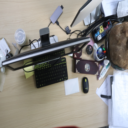

In [65]:
image_query = X_test[check_index].view(1,-1)
label_query = Y_test[check_index].view(1)
X_total= torch.cat([X_train, image_query], dim=0)
Y_total= torch.cat([Y_train, label_query], dim=0)

test_img = Function.to_pil_image(test_image[check_index])
print('Test image : {}'.format(test_label[check_index].item()))
display(test_img)

In [66]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_total.cpu().detach().numpy())

pairwise_dist_t = _pairwise_distance(X_total)
pairwise_dist_n = pairwise_dist_t.cpu().detach().numpy()

pairwise_dist_sort = np.sort(pairwise_dist_n[-1][:-1])

Query image : 3



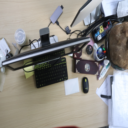



1 second similar 121 second image : 


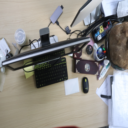



2 second similar 120 second image : 


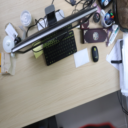



3 second similar 133 second image : 


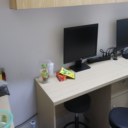



4 second similar 108 second image : 


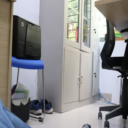



5 second similar 122 second image : 


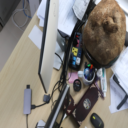

In [67]:
test_img = Function.to_pil_image(test_image[check_index])
print('Query image : {}\n'.format(test_label[check_index].item()))
display(test_img)
print("\n")

for ii in range(5):
  idx = np.where( pairwise_dist_n[-1] == pairwise_dist_sort[ii])
  print('{} second similar {} second image : '.format(ii+1,idx[0][0]))
  img = Function.to_pil_image(bef_train_image[idx[0][0]])
  #     img.save('test{}_{}.png'.format(Y_total[ii],ii))
  display(img)
  print("\n")

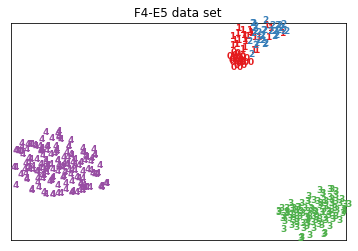

In [58]:
plot_embedding(X_tsne, Y_total,"F4-E5 data set")
plt.show()

In [30]:
X_tsne.shape

(347, 2)